# The XXZ chain with importance sampling
we study the spin-$1/2$  XXZ chain with $L=16$ sites, a model where people have also related sampling problems in the past.
The Hamiltonian is 
$$
    H = \sum_{\langle i,j \rangle} \sigma^x_i \sigma^x_j + \sigma^y_i \sigma^y_j + \Delta \sigma^z_i \sigma^z_j
$$
where $\sigma^{x,y,z}_i$ denotes the spin-$1/2$ Pauli operators at site $i=1,...,L^2$, and $\langle...\rangle$ indicate pairs of nearest neighbors sites.
This notebook takes around 15 minutes to run on a modern GPU.

When using an RBM, the benefits from importance sampling are pretty striking. With a small number of samples, traditional VMC is not able to converge, whereas importance sampling helps reach a much better energy, more than 3 orders of magnitude better!

In [1]:
import netket as nk 
import matplotlib.pyplot as plt 
import optax
import jax.numpy as jnp
from netket.callbacks import InvalidLossStopping

import advanced_drivers as advd
from grad_sample.models import XXZ
from grad_sample.utils import e_diag, save_exact_err

In [2]:
# Define VMC hparams
Ns = 2**9
n_iter = 2000
lr = 0.0025                 
diag_shift = 1e-4

opt = optax.sgd(learning_rate=lr)

In [3]:
model = XXZ(L=16, J=1.5)

def create_vstate():
    ansatz = nk.models.RBM(alpha=3, 
                param_dtype= complex)

    sampler = nk.sampler.ExactSampler(hilbert = model.hilbert_space)

    vstate = nk.vqs.MCState(sampler= sampler, 
                            model=ansatz, 
                            n_samples= Ns,
                            seed=42
                            )
    return vstate

As a reference for the optimization, we compute the exact ground state energy

In [4]:
E_gs = e_diag(model.hamiltonian.to_sparse())
print('The ground state energy is %.4f'%E_gs)

The ground state energy is -33.7111


## Testing importance sampling
We will compare 3 sampling strategies:
- the usual one where we sample from $|\psi|^2$
- sampling from $|\psi|$
- adaptive tuning of the overdispersion coefficient $|\psi|^\alpha$

For a fair comparison, we will compute the variational energies in exact summation.

### Sampling from $|\psi|^2$
Let's start by the usual case where we sample from the Born amplitude

In [5]:
vstate = create_vstate()
driver =advd.driver.VMC_NG(hamiltonian=model.hamiltonian.to_jax_operator(), 
                            optimizer=opt, 
                            variational_state=vstate, 
                            diag_shift=diag_shift, 
                            use_ntk=False,
                            on_the_fly=False)
out_psi_sq = nk.logging.RuntimeLog()
fs_state_err = nk.vqs.FullSumState(hilbert = vstate.hilbert, 
                                        model = vstate.model,  
                                        seed=0)
driver.run(n_iter = n_iter, out = out_psi_sq, callback = (InvalidLossStopping(), save_exact_err(fs_state_err, E_gs, save_every=10)))

100%|█| 2000/2000 [02:27<00:00, 13.57it/s, Energy=-29.4-


(RuntimeLog():
  keys = ['Energy', 'rel_err'],)

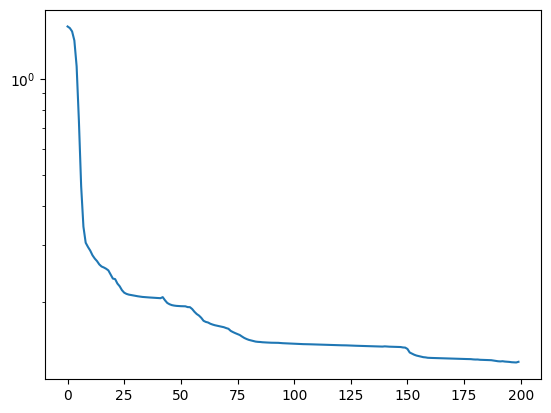

In [6]:
plt.plot(out_psi_sq['rel_err'])
plt.yscale('log')

### Sampling from $|\psi|$
Now, we can test what Chen and Heyl proposed in the MinSR paper that is to sample from the modulus of the neural wave function.

In [7]:
modulus_distribution = advd.driver.overdispersed_distribution(alpha=1.0)
vstate = create_vstate()
driver =advd.driver.VMC_NG(hamiltonian=model.hamiltonian.to_jax_operator(), 
                            optimizer=opt, 
                            sampling_distribution = modulus_distribution, #here we specified the new sampling distribution
                            variational_state=vstate, 
                            diag_shift=diag_shift, 
                            use_ntk=False,
                            on_the_fly=False)

out_psi_mod = nk.logging.RuntimeLog()
fs_state_err = nk.vqs.FullSumState(hilbert = vstate.hilbert, 
                                    model = vstate.model,  
                                    seed=0)
driver.run(n_iter = n_iter, out = out_psi_mod, callback = (InvalidLossStopping(), save_exact_err(fs_state_err, E_gs, save_every=10)))

100%|█| 2000/2000 [03:52<00:00,  8.62it/s, Energy=-33.71


(RuntimeLog():
  keys = ['Energy', 'rel_err'],)

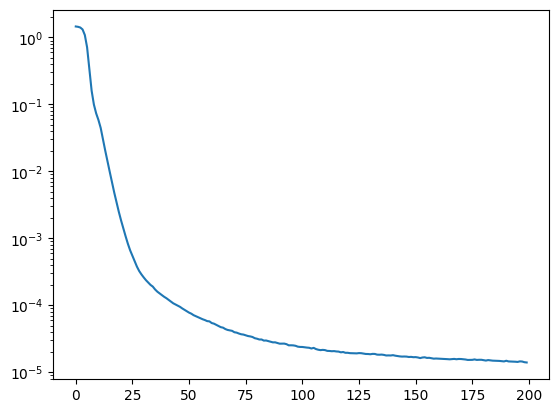

In [8]:
plt.plot(out_psi_mod['rel_err'])
plt.yscale('log')

### Adaptive tuning
Now let's try adaptive tuning of the overdispersion factor to see if we gain any extra benefit from it.

In [9]:
modulus_distribution = advd.driver.overdispersed_distribution(alpha=2.0)
vstate = create_vstate()
driver =advd.driver.VMC_NG(hamiltonian=model.hamiltonian.to_jax_operator(), 
                            optimizer=opt, 
                            sampling_distribution = modulus_distribution, #here we specified the new sampling distribution
                            variational_state=vstate, 
                            diag_shift=diag_shift, 
                            use_ntk=False,
                            auto_is=True,
                            on_the_fly=False)

out_psi_auto = nk.logging.RuntimeLog()
fs_state_err = nk.vqs.FullSumState(hilbert = vstate.hilbert, 
                                    model = vstate.model,  
                                    seed=0)
driver.run(n_iter = n_iter, out = out_psi_auto, callback = (InvalidLossStopping(), save_exact_err(fs_state_err, E_gs, save_every=10)))

100%|█| 2000/2000 [04:21<00:00,  7.64it/s, Energy=-33.70


(RuntimeLog():
  keys = ['Energy', 'info', 'rel_err'],)

### Let's compare !

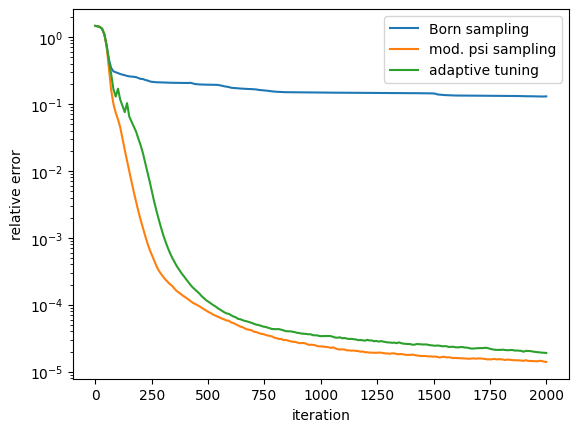

In [11]:
plt.plot(jnp.linspace(0,n_iter,n_iter//10), out_psi_sq['rel_err'], label = 'Born sampling')
plt.plot(jnp.linspace(0,n_iter,n_iter//10), out_psi_mod['rel_err'], label = 'mod. psi sampling')
plt.plot(jnp.linspace(0,n_iter,n_iter//10), out_psi_auto['rel_err'], label = 'adaptive tuning')

plt.ylabel('relative error')
plt.xlabel('iteration')

plt.yscale('log')

plt.legend()
plt.show()

Let's look at the adaptive tuning trajectory as well:

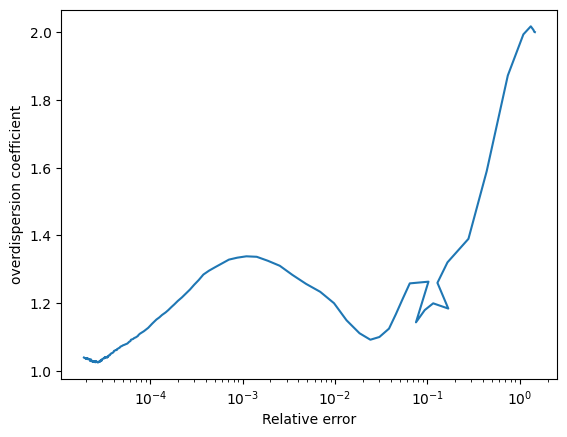

In [12]:
plt.plot(out_psi_auto['rel_err'], out_psi_auto['info']['alpha'][::10])
plt.xlabel('Relative error')
plt.ylabel('overdispersion coefficient')
plt.xscale('log')